In [726]:
from skimage.transform import resize
import numpy as np
import glob
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import warnings
warnings.filterwarnings('ignore')

## Data visualization and pre-processing

In [727]:
def image_load(path):
    with open(path) as img:
        image_array = np.fromfile(img, dtype=np.uint8).reshape(1024,-1)
    return image_array

def load_labels_coordinates(path):
    with open(path) as gt:
        gt_new = np.genfromtxt(path, delimiter=" ").reshape(-1,4)
    return gt_new

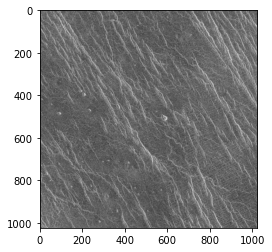

In [900]:
#Raw image sample
loaded_image = image_load("./data/package/Images/img4.sdt")
plt.imshow(loaded_image,cmap = 'gray')
plt.show()

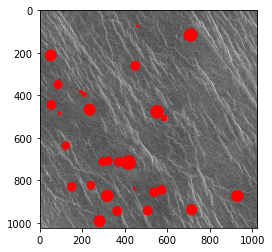

In [901]:
#image sample with volcanoes marked
#reference https://matplotlib.org/stable/gallery/shapes_and_collections/patch_collection.html
def show_volcano_patches(image_path):
    img = Load_image(image_path)
    file_name = image_path.split("\\")[-1].split(".")[0]
    gt = load_labels_coordinates('./data/package/GroundTruths/' + file_name + '.lxyr')
    fig,ax = plt.subplots(1)
    ax.set_aspect('equal')
    x = gt[:,1]
    y = gt[:,2]
    r = gt[:,3]
    for _x,_y,_r in zip(x,y,r):
        patch = Circle((_x,_y),_r,color="red")
        ax.add_patch(patch)
    plt.imshow(img,cmap = 'gray')
    plt.show()
    
show_volcano_patches("./data/package/Images\img4.sdt")

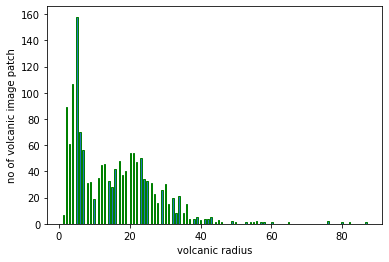

Maximum length radius =  87.0
Mean length radius =  15.371052631578948
most frequent radius of volcanoes 5.0


In [730]:
#check radius distribution of volcanoes
def radius_dist_of_volcanoes():
    img_path = './data/package/Images/*.sdt'
    radius_list = []
    for filename in glob.glob(img_path):
        image_array = image_load(filename)
        file_name = filename.split("\\")[-1].split(".")[0]
        lxyr_path = './data/package/GroundTruths/' + file_name + '.lxyr'
        gt_new = load_labels_coordinates(lxyr_path)
        
        # check for volcanoes
        if np.any(gt_new):
            r = gt_new[:, 3].astype(int)
            for radius in r:
                radius_list= np.append(radius_list,radius)
    plt.hist(radius_list,bins=200,ec="green")
    plt.xlabel('volcanic radius')
    plt.ylabel('no of volcanic image patch')
    plt.show()
    print("Maximum length radius = ",radius_list.max())
    print("Mean length radius = ",radius_list.mean())
    values, counts = np.unique(radius_list, return_counts=True)
    print("most frequent radius of volcanoes",values[np.argmax(counts)])
radius_dist_of_volcanoes()

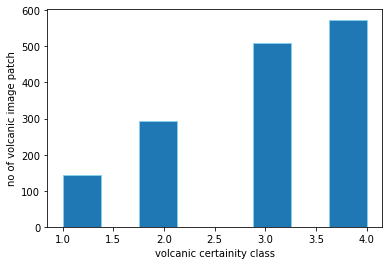

most frequent certainity class 4.0


In [731]:
#show confidence distribution of volcanoes
def confidence_dist_of_volcanoes():
    img_path = './data/package/Images/*.sdt'
    confidence_list = []
    for filename in glob.glob(img_path):
        image_array = image_load(filename)
        file_name = filename.split("\\")[-1].split(".")[0]
        lxyr_path = './data/package/GroundTruths/' + file_name + '.lxyr'
        gt_new = load_labels_coordinates(lxyr_path)
        
        # check for volcanoes
        if np.any(gt_new):
            conf = gt_new[:, 0].astype(int)
            for confidence in conf:
                confidence_list= np.append(confidence_list,confidence)
    plt.hist(confidence_list,bins=8,ec="skyblue")
    plt.xlabel('volcanic certainity class')
    plt.ylabel('no of volcanic image patch')
    plt.show()
    values, counts = np.unique(confidence_list, return_counts=True)
    print("most frequent certainity class",values[np.argmax(counts)])

confidence_dist_of_volcanoes()

### Code to crop image

In [732]:
def crop_images():
    img_path = './data/package/Images/*.sdt'
    features = []
    labels = []
    for filename in glob.glob(img_path):
        image_array = image_load(filename)
        file_name = filename.split("\\")[-1].split(".")[0]
        lxyr_path = './data/package/GroundTruths/' + file_name + '.lxyr'
        gt_new = load_labels_coordinates(lxyr_path)
        # check if volcanoes are present
        if np.any(gt_new):
            label = gt_new[:, 0]
            x = gt_new[:, 1].astype(int)
            y = gt_new[:, 2].astype(int)
            r = gt_new[:, 3].astype(int)
            for label, x_array, y_array, radius in zip(label, x, y, r):
                if not ((y_array < radius) or(x_array < radius)): 
                    #cannot crop the image if radius is larger than one of the coordinates as the circular patch of volcano might not be complete.
                    img = image_array[y_array - int(radius):y_array + int(radius), x_array - int(radius):x_array + int(radius)]
                    img_reshaped = resize(img, (50, 50),anti_aliasing=False)
                    #flattening the image array as PCA implementation takes only takes two dimensions.
                    features.append(img_reshaped.ravel().astype(float))
                    labels.append(label)
    return features,labels

In [733]:
features,labels = crop_images()

In [734]:
len(features)

1505

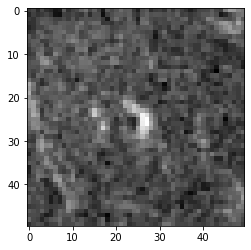

In [735]:
#showing cropped image patch for a single volcanic patch
plt.imshow(features[1].reshape((50,50)),cmap = 'gray')
plt.show()

## PCA Implementation

In [736]:
#Reference: https://kozodoi.me/blog/20230326/pca-from-scratch
class PCA:
    
    def __init__(self, num_of_features):
        self.variance = None
        self.num_of_features = num_of_features
        self.features     = []
        self.mean           = []
    
    
    def fit(self, data_matrix):
        # Function to find principal component
        
        #Normalizing the data
        self.mean = np.mean(data_matrix, axis = 0)
        data_matrix = data_matrix - self.mean
        
        # finding and Sorting Eigen values and Eigen vectors
        cov_matrix = np.cov(data_matrix.T)
        eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)
        sorted_ids = np.argsort(eigen_values)[::-1]
        eigen_values   = eigen_values[sorted_ids]
        eigen_vectors  = eigen_vectors[:, sorted_ids]
        
        # selecting the given number of principal component from sorted list
        self.features = eigen_vectors[:self.num_of_features]
        
        # Keeping the variance ratio of each principal
        self.variance = eigen_values[:self.num_of_features]/np.sum(eigen_values[:self.num_of_features])
    
    
    def transform(self, data_matrix):
        #tranforming data only representing most important pca component
        
        # Normalizing data
        data_matrix = data_matrix - self.mean
        
        return np.dot(data_matrix, self.features.T)

In [737]:
pca = PCA(150)
pca.fit(np.array(features))
print("variance ratio of first 10 component: ",pca.variance[:10])

variance ratio of first 10 component:  [0.59243827+0.j 0.12862737+0.j 0.05390993+0.j 0.02802238+0.j
 0.02018445+0.j 0.01780323+0.j 0.0137941 +0.j 0.01164624+0.j
 0.00828358+0.j 0.00813238+0.j]


In [738]:
transformed_feature_matrix = pca.transform(np.array(features))
transformed_feature_matrix.shape

(1505, 150)

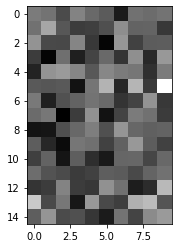

displaying image using selected PCA components


In [739]:
plt.imshow(transformed_feature_matrix[1].reshape((15,10)).astype(float),cmap = 'gray')
plt.show()
print("displaying image using selected PCA components")

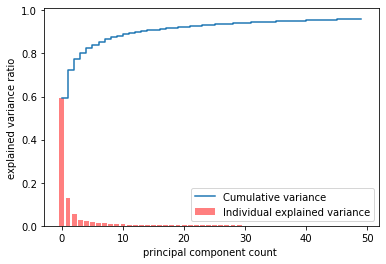

In [740]:
variance_cumulative = np.cumsum(pca.variance[:50])
plt.step(range(0,len(variance_cumulative)), variance_cumulative, where='post',label='Cumulative variance')
plt.bar(range(0,len(pca.variance[:50])), pca.variance[:50], alpha=0.5, align='center', label='Individual explained variance',color="red")
plt.ylabel('explained variance ratio')
plt.xlabel('principal component count ')
plt.legend()
plt.show()

In [741]:
transformed_feature_matrix[:,0]
variance_cumulative[-1]

(0.961244047855482+0j)

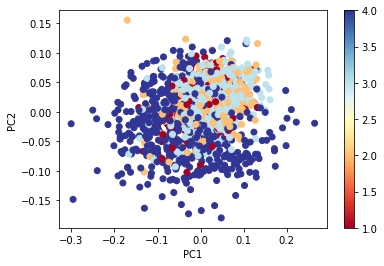

Scatter plot for PC1 and PC2


In [742]:
plt.scatter(transformed_feature_matrix[:,0], transformed_feature_matrix[:,1], c = labels,cmap='RdYlBu')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()
print("Scatter plot for PC1 and PC2")

## Dataset split

In [743]:
def dataset_split(train,test):
    training_split_end = int(train.shape[0]*0.8)
    x_train,y_train =  train[:training_split_end,],test[:training_split_end]
    x_test,y_test = train[training_split_end:,],test[training_split_end:]
    
    return x_train,y_train,x_test,y_test 
    

In [744]:
x_train,y_train,x_test,y_test = dataset_split(transformed_feature_matrix,np.array(labels))

## Simple KNN implementation

In [745]:
#Used the implementation from my ML assignment 1
def cartesian_dist(p,q):
    """
        This function calculates euclidean distance between two cartesian points.
    """
    return np.sqrt(np.sum(np.square(p-q)))

def knn(train_features, train_targets, data_point ,k=1):
    """

    Parameters
    ----------
        train_features : a*b numpy array (a= number of samples, b=number of features in each sample)
        train_targets : c*1 numpy array(c: respective targets for each sample of a)
        data_point : one set of features to test or compare
        k : it's a integer representing number of neighbours to compare with

    Returns
    -------
        distance of k neighbours
        results/targets of nearest neighbours

    """
    
    _neighbour = []
    _dist = []
    for _index in range(len(train_features)):
        _dist.append(cartesian_dist(train_features[_index], data_point))
            
    sorted_indices = np.argsort(_dist)  #This functions sorts the array and provides their index in a sorted manner.
    _dist.sort()
    for _k in range(k):
        _neighbour.append(_dist[_k])
    _target = [train_targets[x] for x in sorted_indices[:k]] #Here all the probable targets are obtained as per the k value.
    
    return _neighbour,_target

## KNN with different k values and majority voting to select the frequent target label.

In [746]:
for k in range(1,6):
    values_predicted=[]
    for i in range(x_test.shape[0]):
        neighbour,_targets = knn(x_train, y_train, x_test[i],k)
        unique_items, item_counts = np.unique(_targets, return_counts = True)
        values_predicted.append(unique_items[np.where(item_counts == item_counts.max())][0])
        
    test_accuracy = np.sum(np.array(values_predicted) == y_test) / len(y_test) * 100
    
    values_predicted=[]
    for i in range(x_train.shape[0]):
        neighbour,_targets = knn(x_train, y_train, x_train[i],k)
        unique_items, item_counts = np.unique(_targets, return_counts = True)
        values_predicted.append(unique_items[np.where(item_counts == item_counts.max())][0])
    train_accuarcy = np.sum(np.array(values_predicted) == y_train) / len(y_train) * 100
    print("with k = ",k,"Test Accuracy: ",test_accuracy,"%"," Train Accuracy: ",train_accuarcy,"%")

with k =  1 Test Accuracy:  65.78073089700996 %  Train Accuracy:  100.0 %
with k =  2 Test Accuracy:  63.12292358803987 %  Train Accuracy:  86.79401993355482 %
with k =  3 Test Accuracy:  68.10631229235881 %  Train Accuracy:  80.39867109634552 %
with k =  4 Test Accuracy:  70.09966777408638 %  Train Accuracy:  77.65780730897009 %
with k =  5 Test Accuracy:  70.09966777408638 %  Train Accuracy:  74.91694352159467 %
with k =  6 Test Accuracy:  72.75747508305648 %  Train Accuracy:  74.16943521594685 %
with k =  7 Test Accuracy:  73.75415282392026 %  Train Accuracy:  72.59136212624585 %
with k =  8 Test Accuracy:  72.09302325581395 %  Train Accuracy:  73.67109634551495 %
with k =  9 Test Accuracy:  72.75747508305648 %  Train Accuracy:  72.42524916943522 %
with k =  10 Test Accuracy:  73.421926910299 %  Train Accuracy:  71.17940199335548 %


## KNN with different K values and different PC values

In [747]:
for pc in [2,10,50,100,150]:
    pca = PCA(pc)
    pca.fit(np.array(features))
    transformed_feature_matrix = pca.transform(np.array(features))
    x_train,y_train,x_test,y_test = dataset_split(transformed_feature_matrix,np.array(labels))
    variance_cumulative = np.cumsum(pca.variance[:50])
    print("Number of principal component: ",pc)
    for k in range(1,5):
        values_predicted=[]
        for i in range(x_test.shape[0]):
            neighbour,_targets = knn(x_train, y_train, x_test[i],k)
            unique_items, item_counts = np.unique(_targets, return_counts = True)
            values_predicted.append(unique_items[np.where(item_counts == item_counts.max())][0])

        test_accuracy = np.sum(np.array(values_predicted) == y_test) / len(y_test) * 100

        values_predicted=[]
        for i in range(x_train.shape[0]):
            neighbour,_targets = knn(x_train, y_train, x_train[i],k)
            unique_items, item_counts = np.unique(_targets, return_counts = True)
            values_predicted.append(unique_items[np.where(item_counts == item_counts.max())][0])
        train_accuarcy = np.sum(np.array(values_predicted) == y_train) / len(y_train) * 100
        print("with k = ",k,"Test Accuracy: ",test_accuracy,"%"," Train Accuracy: ",train_accuarcy,"%")

Number of principal component:  2
with k =  1 Test Accuracy:  45.182724252491695 %  Train Accuracy:  100.0 %
with k =  2 Test Accuracy:  36.544850498338874 %  Train Accuracy:  72.17607973421927 %
with k =  3 Test Accuracy:  44.18604651162791 %  Train Accuracy:  66.86046511627907 %
with k =  4 Test Accuracy:  47.840531561461795 %  Train Accuracy:  67.02657807308971 %
Number of principal component:  10
with k =  1 Test Accuracy:  58.80398671096345 %  Train Accuracy:  100.0 %
with k =  2 Test Accuracy:  52.823920265780735 %  Train Accuracy:  80.64784053156147 %
with k =  3 Test Accuracy:  60.46511627906976 %  Train Accuracy:  76.99335548172758 %
with k =  4 Test Accuracy:  63.12292358803987 %  Train Accuracy:  74.08637873754152 %
Number of principal component:  20
with k =  1 Test Accuracy:  61.461794019933556 %  Train Accuracy:  100.0 %
with k =  2 Test Accuracy:  59.136212624584715 %  Train Accuracy:  82.22591362126246 %
with k =  3 Test Accuracy:  68.10631229235881 %  Train Accuracy:  

## K fold cross validation

In [748]:
def k_fold_cross_validation(features, targets, k_fold=5, knn_k=1):
    fold_size = len(features) // k_fold
    indices = np.arange(len(features))

    test_results = []
    train_results = []

    for i in range(k_fold):
        index_test = indices[i * fold_size: (i + 1) * fold_size]
        index_train = np.concatenate((indices[:i * fold_size], indices[(i + 1) * fold_size:]))

        x_train = features[index_train]
        y_train = targets[index_train]
        x_test = features[index_test]
        y_test = targets[index_test]

        #model training with k fold and obtaining results
        values_predicted=[]
        for j in range(x_test.shape[0]):
            neighbour,_targets = knn(x_train, y_train, x_test[j],knn_k)
            unique_items, item_counts = np.unique(_targets, return_counts = True)
            values_predicted.append(unique_items[np.where(item_counts == item_counts.max())][0])

        test_accuracy = np.sum(np.array(values_predicted) == y_test) / len(y_test) * 100
        test_results.append(test_accuracy)

        values_predicted=[]
        for i in range(x_train.shape[0]):
            neighbour,_targets = knn(x_train, y_train, x_train[i],k)
            unique_items, item_counts = np.unique(_targets, return_counts = True)
            values_predicted.append(unique_items[np.where(item_counts == item_counts.max())][0])
        train_accuarcy = np.sum(np.array(values_predicted) == y_train) / len(y_train) * 100
        train_results.append(train_accuarcy)

    
    mean_accuracy_test = np.mean(test_results)
    mean_accuracy_train = np.mean(train_results)

    return mean_accuracy_test,mean_accuracy_train

In [749]:
pca = PCA(150)
pca.fit(np.array(features))
transformed_feature_matrix = pca.transform(np.array(features))
x_train,y_train,x_test,y_test = dataset_split(transformed_feature_matrix,np.array(labels))
test_accuracy,train_accuarcy = k_fold_cross_validation(transformed_feature_matrix,np.array(labels),2,1)

In [750]:
test_accuracy,train_accuarcy

(59.50797872340425, 78.02124833997344)

## Testing KNN with different kfold values, PC values and K values in KNN

In [751]:
for PC in [10,50,100,150]:
    pca = PCA(150)
    pca.fit(np.array(features))
    transformed_feature_matrix = pca.transform(np.array(features))
    x_train,y_train,x_test,y_test = dataset_split(transformed_feature_matrix,np.array(labels))
    print("Number of principal components: ",PC)
    
    for k_fold in [2,5,6]:
        print("K-fold: ", k_fold)
        for k in [1,2,5]:
            test_accuracy,train_accuarcy = k_fold_cross_validation(transformed_feature_matrix,np.array(labels),k_fold,k)
            print("with KNN k: ",k," test accuracy:",test_accuracy," train accuracy: ",train_accuarcy)
    print("-------------------")
    

Number of principal components:  10
K-fold:  2
with KNN k:  1  test accuracy: 59.50797872340425  train accuracy:  100.0
with KNN k:  2  test accuracy: 56.25  train accuracy:  87.05179282868525
with KNN k:  3  test accuracy: 59.375  train accuracy:  80.27888446215138
with KNN k:  5  test accuracy: 60.837765957446805  train accuracy:  76.56042496679947
K-fold:  5
with KNN k:  1  test accuracy: 61.5282392026578  train accuracy:  100.0
with KNN k:  2  test accuracy: 59.66777408637874  train accuracy:  88.6046511627907
with KNN k:  3  test accuracy: 62.59136212624585  train accuracy:  81.46179401993356
with KNN k:  5  test accuracy: 62.79069767441861  train accuracy:  76.62790697674419
K-fold:  6
with KNN k:  1  test accuracy: 61.86666666666667  train accuracy:  100.0
with KNN k:  2  test accuracy: 61.26666666666667  train accuracy:  88.69853917662682
with KNN k:  3  test accuracy: 62.79999999999999  train accuracy:  81.31474103585657
with KNN k:  5  test accuracy: 64.13333333333333  train 

## Weighted KNN class acuuracy comaprison with majority vote KNN class accuracy

In [ ]:
pca = PCA(150)
pca.fit(np.array(features))
transformed_feature_matrix = pca.transform(np.array(features))
x_train,y_train,x_test,y_test = dataset_split(transformed_feature_matrix,np.array(labels))

#### Majority vote KNN

In [898]:
print("[class=1,class=2,class=3,class=4]")
for k in range(1,6):
    values_predicted=[]
    class_accuracies = []
    for i in range(x_test.shape[0]):
        neighbour,_targets = knn(x_train, y_train, x_test[i],k)
        unique_items, item_counts = np.unique(_targets, return_counts = True)
        values_predicted.append(unique_items[np.where(item_counts == item_counts.max())][0])
    
    #getting Individual class accuarcy
    for _label in [1,2,3,4]:
        label_x_pred = np.where(np.array(values_predicted) == _label)
        labelx_test = np.where(y_test == _label)
        label_x_match = np.in1d(labelx_test,label_x_pred)
        label_x_acc = np.sum(label_x_match)/labelx_test[0].shape[0]
        class_accuracies.append(label_x_acc)
    print("for k = ",k)
    print("accuracies = ",class_accuracies)

[class=1,class=2,class=3,class=4]
for k =  1
accuracies =  [0.2857142857142857, 0.2553191489361702, 0.5412844036697247, 0.9758064516129032]
for k =  2
accuracies =  [0.47619047619047616, 0.425531914893617, 0.4036697247706422, 0.9354838709677419]
for k =  3
accuracies =  [0.38095238095238093, 0.2978723404255319, 0.5871559633027523, 0.9596774193548387]
for k =  4
accuracies =  [0.3333333333333333, 0.3617021276595745, 0.6238532110091743, 0.9596774193548387]
for k =  5
accuracies =  [0.23809523809523808, 0.2765957446808511, 0.6880733944954128, 0.9516129032258065]


#### Weighted KNN

In [899]:
print("[class=1,class=2,class=3,class=4]")
for k in range(1,6):
    values_predicted=[]
    class_accuracies = []
    for i in range(x_test.shape[0]):
        neighbour,_targets = knn(x_train, y_train, x_test[i],k)
        unique_items, item_counts = np.unique(_targets, return_counts = True)
        weights = np.ones(k)
        for i, class_ in enumerate(unique_items):
            class_weight = len(_targets) / (k * item_counts[i])
            weights[_targets == class_] *= class_weight

        values_predicted.append(np.argmax(np.bincount(_targets, weights=weights)))

    test_accuracy = np.sum(np.array(values_predicted) == y_test) / len(y_test) * 100
    
    #getting Individual class accuarcy
    for _label in [1,2,3,4]:
        label_x_pred = np.where(np.array(values_predicted) == _label)
        labelx_test = np.where(y_test == _label)
        label_x_match = np.in1d(labelx_test,label_x_pred)
        label_x_acc = np.sum(label_x_match)/labelx_test[0].shape[0]
        class_accuracies.append(label_x_acc)
    
    print("for k = ",k)
    print("accuracies = ",class_accuracies)

[class=1,class=2,class=3,class=4]
for k =  1
accuracies =  [0.2857142857142857, 0.2553191489361702, 0.5412844036697247, 0.9758064516129032]
for k =  2
accuracies =  [0.47619047619047616, 0.425531914893617, 0.4036697247706422, 0.9354838709677419]
for k =  3
accuracies =  [0.6190476190476191, 0.46808510638297873, 0.29357798165137616, 0.9112903225806451]
for k =  4
accuracies =  [0.6666666666666666, 0.48936170212765956, 0.1743119266055046, 0.8790322580645161]
for k =  5
accuracies =  [0.7142857142857143, 0.48936170212765956, 0.13761467889908258, 0.8306451612903226]
